In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [14]:
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 127.5 - 1.0  
x_train = np.expand_dims(x_train, axis=-1)
x_train = x_train.astype(np.float32)
img_shape = (28,28,1)
z_dim = 100

In [15]:
def build_generator(z_dim):
    model = models.Sequential()
    model.add(layers.Dense(7*7*128, input_dim=z_dim))
    model.add(layers.Reshape((7,7,128)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'))
    return model

In [16]:
def build_critic(img_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  
    return model

In [17]:
def gradient_penalty(critic, real, fake, batch_size):
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1., dtype=tf.float32)
    interpolated = alpha * real + (1 - alpha) * fake

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)
    grads = tape.gradient(pred, interpolated)
    grads = tf.reshape(grads, [grads.shape[0], -1])
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((grad_norm - 1.0)**2)
    return gp

In [18]:
generator = build_generator(z_dim)
critic = build_critic(img_shape)

g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)
c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0, beta_2=0.9)

lambda_gp = 10.0 
n_critic = 5
batch_size = 64

In [19]:
def sample_images(generator, epoch, z_dim=100, n_samples=10):
    noise = np.random.normal(0, 1, (n_samples, z_dim))
    gen_imgs = generator.predict(noise, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  

    fig, axs = plt.subplots(1, n_samples, figsize=(n_samples,1))
    for i in range(n_samples):
        axs[i].imshow(gen_imgs[i,:,:,0], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [20]:
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    for _ in range(n_critic):
        noise = tf.random.normal([batch_size, z_dim])
        with tf.GradientTape() as tape:
            fake_images = generator(noise, training=True)
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)
            
            gp = gradient_penalty(critic, real_images, fake_images, batch_size)
            c_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + lambda_gp * gp

        c_grads = tape.gradient(c_loss, critic.trainable_variables)
        c_optimizer.apply_gradients(zip(c_grads, critic.trainable_variables))

    noise = tf.random.normal([batch_size, z_dim])
    with tf.GradientTape() as tape:
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        g_loss = -tf.reduce_mean(fake_output)

    g_grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return c_loss, g_loss

In [21]:
def train_wgan_gp(epochs, sample_interval=1000):
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]

        c_loss, g_loss = train_step(real_imgs)

        if epoch % sample_interval == 0:
            print(f"{epoch} [C loss: {c_loss:.4f}] [G loss: {g_loss:.4f}]")
            sample_images(generator, epoch)

0 [C loss: 7.2489] [G loss: 0.0283]


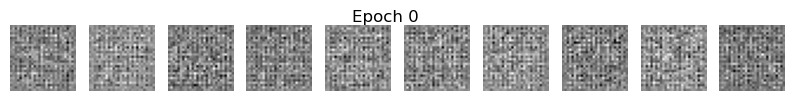

1000 [C loss: -1.1795] [G loss: -2.5547]


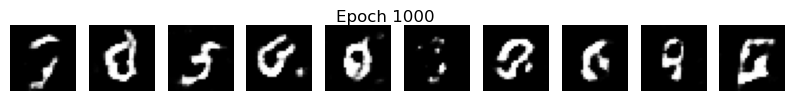

2000 [C loss: -1.4891] [G loss: -5.1045]


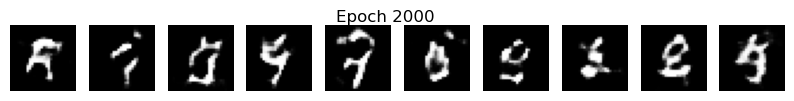

3000 [C loss: -0.6929] [G loss: -8.7570]


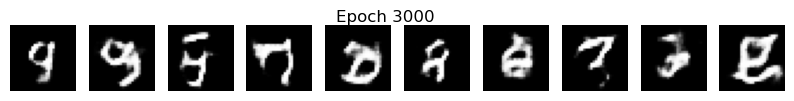

4000 [C loss: -1.0481] [G loss: -9.1838]


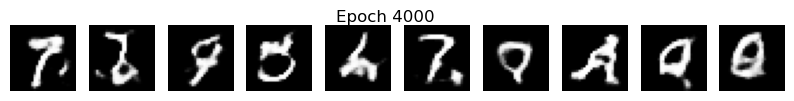

In [22]:
train_wgan_gp(epochs=5000, sample_interval=1000)